# Room Dimensions

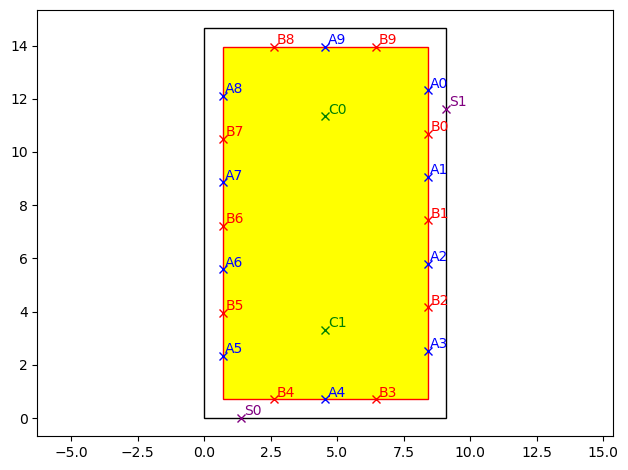

In [1]:
# Given specs
from networkx import all_shortest_paths


depth_m = 14.65
width_m = 9.1
height_m = 8.35

# Guessed specs
border_m = 0.7
depth_step_m = (depth_m - 2*border_m - 2*0.1)/8
width_step_m = (width_m - 2*border_m)/4
sw_height_m = 0.1 # on the floor

# speaker columns
col_heights_m = {
    'A': 1.5,
    'B': 3.25,
    'C': 5,
    'S': sw_height_m,
}

colors = {
    'A': 'blue',
    'B': 'red',
    'C': 'green',
    'S': 'purple',
}
speakers_right = ['A0', 'B0', 'A1', 'B1', 'A2', 'B2', 'A3']
speakers_left = ['A5', 'B5', 'A6', 'B6', 'A7', 'B7', 'A8']

all_speaker_coords_m = {}
for col in ['A', 'B', 'C', 'S']:
    if col in ['A', 'B']:
        max_id = 9
    elif col in ['C', 'S']:
        max_id = 1

    for id in range(max_id+1):
        speaker_id = f'{col}{id}'
        # placeholder coords
        speaker_coords_m = [-1]*3 # x(width), y(depth), z(height)

        speaker_coords_m[2] = col_heights_m[col]

        if speaker_id in speakers_right: # right edge
            speaker_coords_m[0] = width_m - border_m
            speaker_coords_m[1] = depth_m - border_m - depth_step_m*(1+speakers_right.index(speaker_id))

        elif speaker_id in ['B3', 'A4', 'B4']: # bottom edge
            speaker_coords_m[1] = border_m

            if speaker_id == 'B3':
                speaker_coords_m[0] = width_m - border_m - width_step_m
            elif speaker_id == 'A4':
                speaker_coords_m[0] = width_m - border_m - 2*width_step_m
            elif speaker_id == 'B4':
                speaker_coords_m[0] = width_m - border_m - 3*width_step_m
                
        elif speaker_id in speakers_left:
            speaker_coords_m[0] = border_m
            speaker_coords_m[1] = border_m + depth_step_m*(1+speakers_left.index(speaker_id))

        elif speaker_id in ['B8', 'A9', 'B9']:
            speaker_coords_m[1] = depth_m - border_m

            if speaker_id == 'B8':
                speaker_coords_m[0] = border_m + width_step_m
            elif speaker_id == 'A9':
                speaker_coords_m[0] = border_m + 2*width_step_m
            elif speaker_id == 'B9':
                speaker_coords_m[0] = border_m + 3*width_step_m

        elif speaker_id in ['C0', 'C1']:
            speaker_coords_m[0] = border_m + 0.5*(width_m - 2*border_m)

            if speaker_id == 'C0':
                speaker_coords_m[1] = depth_m - (depth_m-2*border_m)/4
            elif speaker_id == 'C1':
                speaker_coords_m[1] = border_m + 2*width_step_m
                speaker_coords_m[1] = (depth_m-2*border_m)/4
        
        all_speaker_coords_m[speaker_id] = speaker_coords_m

all_speaker_coords_m['S0'][0] = 2*border_m
all_speaker_coords_m['S0'][1] = 0
all_speaker_coords_m['S1'][0] = width_m
all_speaker_coords_m['S1'][1] = all_speaker_coords_m['A0'][1] - border_m

import matplotlib.pyplot as plt
import matplotlib.patches as patches

room = patches.Rectangle(
    (0, 0), 
    width_m, 
    depth_m, 
    linewidth=1, 
    edgecolor='k', 
    facecolor='none',
)

rect_speakers = patches.Rectangle(
    (border_m, border_m), 
    width_m-2*border_m, 
    depth_m-2*border_m, 
    linewidth=1, 
    edgecolor='r', 
    facecolor='yellow',
)

fig, ax = plt.subplots()
ax.add_patch(room)
ax.add_patch(rect_speakers)

for speaker_id in all_speaker_coords_m:
    speaker_x = all_speaker_coords_m[speaker_id][0]
    speaker_y = all_speaker_coords_m[speaker_id][1]
    plt.plot(speaker_x, speaker_y, 'x', c=colors[speaker_id[0]])
    plt.text(speaker_x+0.1, speaker_y+0.1, speaker_id, c=colors[speaker_id[0]])


ax.set_xlim(-1, width_m+1)
ax.set_ylim(bottom = -1, top=depth_m + 1)
plt.axis('equal')
plt.tight_layout()
plt.show()

From [spatialize.js](../spatialize.js), we see we need three columns, corresponding to x, y, and z:
```
function set_trajectory(){
  x_pos = data[ctr][0];
  y_pos = data[ctr][1];
  z_pos = data[ctr][2];

  // Set the source position relative to the room center (source default position).
  source.setPosition(x_pos, y_pos, z_pos);

}
```

We also see that the trajectory is update every 0.1s:
```
function update_trajectory()
{
  if (audioContext.currentTime > next_update_time){
    ctr = ctr + 1;
    set_trajectory();
    console.log("Update no: %d at: %f", ctr, audioContext.currentTime - start_time);
    next_update_time = next_update_time + 0.1;
  }

  if (ctr == ctr_max - 1){
    clearInterval(intID);
    setTimeout(stop_stuff, 300);
  }

}
```

Therefore, we need to make a CSV with:
- three columns, for x, y, and z positions
- one row per 0.1s sample

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.DataFrame()
t_step = 0.1 # seconds, this seems fixed

N_SPEAKERS = 24
N_REPS = 10

duration = N_SPEAKERS * N_REPS * t_step 
tt = np.arange(0, duration - 0.1*t_step, t_step)
tt

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
       11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,
       12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1,
       13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2,
       14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15

In [4]:
df['time_s'] = tt

In [5]:
LISTENER_POS = [width_m/2, depth_m/2, 1.5]

speaker_order = ['C0', 'C1']
speaker_order.extend(speakers_right)
speaker_order.extend(['B3', 'A4', 'B4'])
speaker_order.extend(speakers_left)
speaker_order.extend(['B8', 'A9', 'B9'])
speaker_order.extend(['S0', 'S1'])

traj_x = []
traj_y = []
traj_z = []

for speaker_id in speaker_order:
    x = all_speaker_coords_m[speaker_id][0] - LISTENER_POS[0]
    y = all_speaker_coords_m[speaker_id][1] - LISTENER_POS[1]
    z = all_speaker_coords_m[speaker_id][2] - LISTENER_POS[2]

    for reps in range(N_REPS):
        traj_x.append(x)
        traj_y.append(y)
        traj_z.append(z)
        
df['x'] = traj_x
df['y'] = traj_y
df['z'] = traj_z
df

,time_s,x,y,z
0,0.0,0.00,4.01250,3.5
1,0.1,0.00,4.01250,3.5
2,0.2,0.00,4.01250,3.5
3,0.3,0.00,4.01250,3.5
4,0.4,0.00,4.01250,3.5
...,...,...,...,...
235,23.5,4.55,4.29375,-1.4
236,23.6,4.55,4.29375,-1.4
237,23.7,4.55,4.29375,-1.4
238,23.8,4.55,4.29375,-1.4


In [6]:
df[['x', 'y', 'z']].to_csv(
    f'speakers-{len(speaker_order)}_dur-{duration}-s_step-{t_step}-s.csv',
    header = False, # skip showing column names 
    index = False, # skip row indices
)